# Ratio TOW + Random Forest on this ratio

In [1]:
import os
from dotenv import load_dotenv, dotenv_values 
import datetime

# loading variables from .env file
load_dotenv() 

source_data_folder=os.getenv("SOURCE_FOLDER")
challenge_file=os.getenv("CHALLENGE_FILE")
challenge_file_preproc=os.getenv("CHALLENGE_FILE_PREPROC")
submission_file=os.getenv("SUBMISSION_FILE")
submission_file_preproc=os.getenv("SUBMISSION_FILE_PREPROC")

Training model for category: Medium
country_code_ades_icao is missing in data set!!
RMSE for model of the category Medium is 2430.658091193291


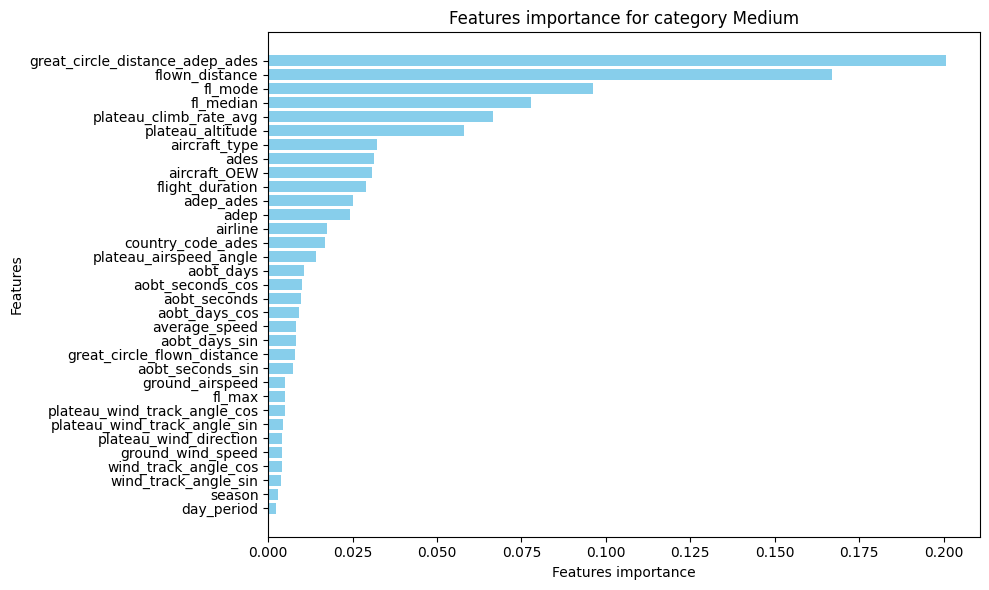

Training model for category: Heavy
RMSE for model of the category Heavy is 7407.501512721802


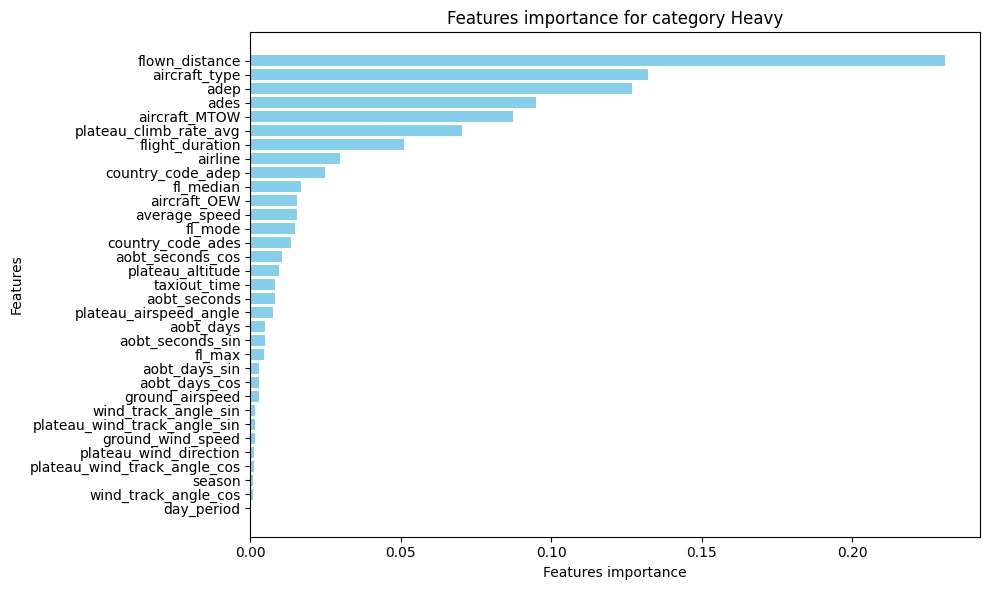

Training model for category: Light
taxi_in is missing in data set!!
RMSE for model of the category Light is 1515.4955974524146


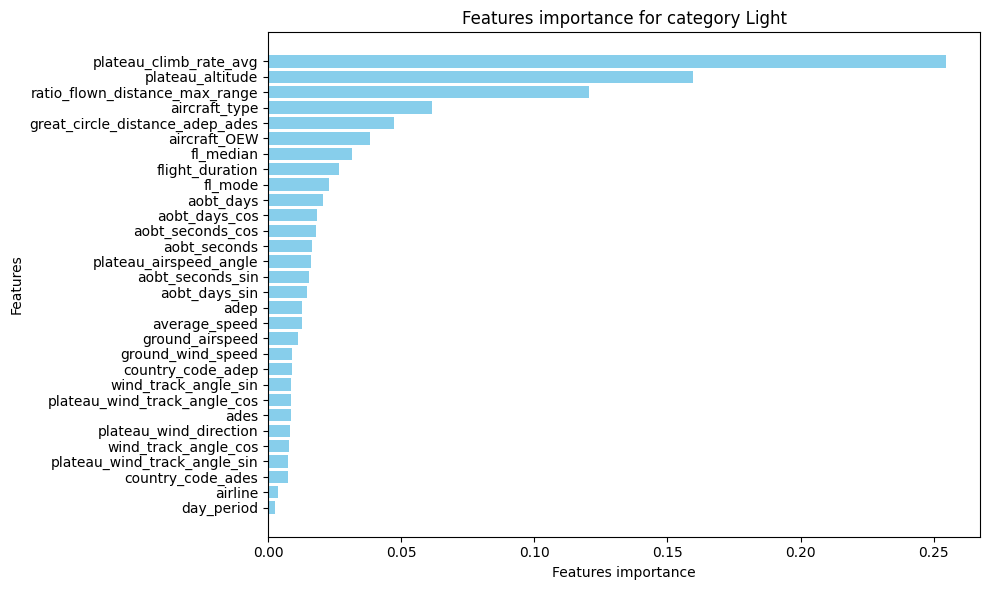

RMSE for category Medium: 2430.66
RMSE for category Heavy: 7407.50
RMSE for category Light: 1515.50


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt  # Import matplotlib for visualizing feature importances

# Load the dataset into a DataFrame
df_flight = pd.read_csv(os.path.join(source_data_folder,challenge_file_preproc))

# Filter the DataFrame to keep only rows where load_ratio is between 0 and 1
df_flight = df_flight[(df_flight['load_ratio'] > 0) & (df_flight['load_ratio'] < 1)]

# List of categorical columns to be encoded
categorical_cols = [
    'adep',
    'country_code_adep',
    'ades',
    'country_code_ades',
    'airline',
    'aircraft_type',
    'wtc'
    #,'country_code_adep_icao',
    #'country_code_ades_icao',
    #'country_code_icao_couple'
]

# Initialize LabelEncoder to convert categorical variables to numerical
le = LabelEncoder()
for col in categorical_cols:
    df_flight[col] = le.fit_transform(df_flight[col])  # Encode each categorical column

# Dictionary to store RMSE results for each aircraft category
rmse_results = {}

# Define the aircraft categories
aircraft_categories = ['Medium', 'Heavy', 'Light']

# Create an output directory for saving models if it doesn't exist
output_dir = './models_by_aircraft_category'
os.makedirs(output_dir, exist_ok=True)

# Loop through each aircraft category to train separate models
for category in aircraft_categories:
    
    print(f'Training model for category: {category}')

    # Select the rows corresponding to the current aircraft category
    df_category = df_flight[df_flight['aircraft_category'] == category]
    
    # If there are no rows for the category, skip to the next category
    if df_category.empty:
        print(f"No data for category: {category}")
        continue

    # Define selected features based on the aircraft category
    if category == 'Medium':
        selected_features = [
            'adep', 'ades', 'flight_duration',
            'great_circle_distance_adep_ades', 'aircraft_type',
            'country_code_ades', 'average_speed',
            'fl_mode','fl_max','fl_median',
            'adep_ades', 'airline', 'great_circle_flown_distance',
            'season', 'day_period',
            'aircraft_OEW', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'country_code_ades_icao',
            #'country_code_adep_icao',
            #'country_code_icao_couple', 'taxi_in', 'aircraft_max_range', 
            'flown_distance'
        ]

    elif category == 'Heavy':
        selected_features = [
            'adep', 'ades', 'flight_duration', 'flown_distance',
            'aircraft_type', 'country_code_ades', 'average_speed',
            'fl_mode','fl_max','fl_median', 'airline', 'taxiout_time',
            'season', 'day_period', 'country_code_adep','aircraft_OEW',
            'aircraft_MTOW', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days'
            #,'country_code_adep_icao', 'country_code_ades_icao'
        ]

    elif category == 'Light':
        selected_features = [
            'adep', 'ades', 'flight_duration',
            'great_circle_distance_adep_ades', 'aircraft_type',
            'country_code_ades', 'average_speed',
            'fl_mode','fl_median', 'airline', 'country_code_adep','aircraft_OEW',
            'day_period', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'taxi_in', 'ratio_flown_distance_max_range'
        ]

# runway_length n'est pas utile
    selected_features_tmp=[]
    for feature in selected_features:
        if feature in df_category.columns:
            selected_features_tmp.append(feature)
        else:
            print("{} is missing in data set!!".format(feature))

    selected_features=selected_features_tmp

    # Prepare features (X) and target variable (y) for the model
    X = df_category[selected_features]
    y = df_category['load_ratio']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the Random Forest Regressor model
    model = RandomForestRegressor(
        n_estimators=3,  # Set the number of trees in the forest
        max_depth=300,      # Set the maximum depth of each tree
        min_samples_split=10,  # Set the minimum number of samples required to split an internal node
        min_samples_leaf=5,    # Set the minimum number of samples required to be at a leaf node
        max_features='sqrt',  # Use the square root of the number of features for splitting
        random_state=42
    )
    
    model.fit(X_train, y_train)  # Fit the model to the training data

    # Predict the load_ratio on the test set
    load_ratio_pred = model.predict(X_test)

    # Create a DataFrame for test data and predicted values
    df_test = X_test.copy()
    df_test['load_ratio_pred'] = load_ratio_pred
    df_test['aircraft_MTOW'] = df_category.loc[X_test.index, 'aircraft_MTOW'].values
    

    # Calculate the predicted 'tow' using the predicted load ratio and updated aircraft_OEW
    df_test['tow_pred'] = df_test['load_ratio_pred'] * (df_test['aircraft_MTOW'] - df_test['aircraft_OEW']) + df_test['aircraft_OEW']


    # Calculate the RMSE for the predictions
    rmse = np.sqrt(mean_squared_error(df_test['tow_pred'], df_category.loc[X_test.index, 'tow']))
    rmse_results[category] = rmse  # Store RMSE for the category

    print(f'RMSE for model of the category {category} is {rmse}')

    # Save the trained model to a .pkl file
    model_filename = os.path.join(output_dir, f'random_forest_model_{category}.pkl')
    joblib.dump(model, model_filename)

    # Get feature importances from the trained model
    feature_importances = model.feature_importances_

    # Sort features and their importances
    sorted_idx = np.argsort(feature_importances)  # Get indices of features sorted by importance
    sorted_features = np.array(selected_features)[sorted_idx]
    sorted_importances = feature_importances[sorted_idx]

    # Visualize feature importances using a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color='skyblue')
    plt.xlabel('Features importance')  # X-axis label
    plt.ylabel('Features')                  # Y-axis label
    plt.title(f'Features importance for category {category}')  # Plot title
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()  # Display the feature importance plot

# Display RMSE results for each aircraft category
for category, rmse in rmse_results.items():
    print(f"RMSE for category {category}: {rmse:.2f}")

# Save RMSE results into a CSV file for further analysis
rmse_df = pd.DataFrame(rmse_results.items(), columns=['Aircraft Category', 'RMSE'])
rmse_df.to_csv('./rmse_results.csv', index=False)  # Save to CSV


# Random Forest With cross validation

In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt  # Import matplotlib for visualizing feature importances

# Load the dataset into a DataFrame
df_flight = pd.read_csv(os.path.join(source_data_folder,challenge_file_preproc))

# Filter the DataFrame to keep only rows where load_ratio is between 0 and 1
df_flight = df_flight[(df_flight['load_ratio'] > 0) & (df_flight['load_ratio'] < 1)]

# List of categorical columns to be encoded
categorical_cols = [
    'adep',
    'country_code_adep',
    'ades',
    'country_code_ades',
    'airline',
    'aircraft_type',
    'wtc', 
    'country_code_adep_icao',
    'country_code_ades_icao',
    'country_code_icao_couple'
]

# Initialize LabelEncoder to convert categorical variables to numerical
le = LabelEncoder()
for col in categorical_cols:
    df_flight[col] = le.fit_transform(df_flight[col])  # Encode each categorical column

# Dictionary to store RMSE results for each aircraft category
rmse_results = {}

# Define the aircraft categories
aircraft_categories = ['Medium', 'Heavy', 'Light']

# Create an output directory for saving models if it doesn't exist
output_dir = './models_by_aircraft_category'
os.makedirs(output_dir, exist_ok=True)

# Loop through each aircraft category to train separate models
for category in aircraft_categories:
    
    print(f'Training model for category: {category}')

    # Select the rows corresponding to the current aircraft category
    df_category = df_flight[df_flight['aircraft_category'] == category]
    
    # If there are no rows for the category, skip to the next category
    if df_category.empty:
        print(f"Aucune donnée pour la catégorie: {category}")
        continue

    # Define selected features based on the aircraft category
    if category == 'Medium':
        selected_features = [
            'adep', 'ades', 'flight_duration',
            'great_circle_distance_adep_ades', 'aircraft_type',
            'country_code_ades', 'average_speed',
            'fl_mode','fl_median'
            'adep_ades', 'airline', 'great_circle_flown_distance',
            'season', 'day_period',
            'aircraft_OEW', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'country_code_ades_icao', 'country_code_adep_icao',
            'country_code_icao_couple', 'taxi_in', 'aircraft_max_range', 'flown_distance'
        ]

    elif category == 'Heavy':
        selected_features = [
            'adep', 'ades', 'flight_duration', 'flown_distance',
            'aircraft_type', 'country_code_ades', 'average_speed',
            'fl_mode','fl_max','fl_median', 'airline', 'taxiout_time',
            'season', 'day_period', 'country_code_adep',
            'aircraft_MTOW', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',                
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'country_code_adep_icao', 'country_code_ades_icao'
        ]

    elif category == 'Light':
        selected_features = [
            'adep', 'ades', 'flight_duration',
            'great_circle_distance_adep_ades', 'aircraft_type',
            'country_code_ades', 'average_speed',
            'fl_mode','fl_median', 'airline', 'country_code_adep',
            'day_period', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'taxi_in', 'ratio_flown_distance_max_range'
        ]

    # Prepare features (X) and target variable (y) for the model
    selected_features_tmp=[]
    for feature in selected_features:
        if feature in df_category.columns:
            selected_features_tmp.append(feature)
        else:
            print("{} is missing in data set!!".format(feature))
    selected_features=selected_features_tmp

    selected_features=selected_features_tmp
    X = df_category[selected_features]
    y = df_category['load_ratio']

    # Create and train the Random Forest Regressor model
    model = RandomForestRegressor(
        n_estimators=100,  # Set the number of trees in the forest
        max_depth=300,      # Set the maximum depth of each tree
        min_samples_split=10,  # Set the minimum number of samples required to split an internal node
        min_samples_leaf=5,    # Set the minimum number of samples required to be at a leaf node
        max_features='sqrt',  # Use the square root of the number of features for splitting
        random_state=42
    )
    
    # Perform cross-validation
    cv_rmse = []
    cv_tow_rmse = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)  # Fit the model to the training data
        load_ratio_pred_cv = model.predict(X_test_cv)  # Predict on the validation set

        # Calculate the RMSE for the load_ratio predictions
        rmse_cv = np.sqrt(mean_squared_error(y_test_cv, load_ratio_pred_cv))
        cv_rmse.append(rmse_cv)
        print(f'RMSE for load_ratio prediction this fold: {rmse_cv:.4f}')  # Display RMSE for load_ratio

        # Calculate 'tow_pred' predictions and RMSE
        tow_pred_cv = load_ratio_pred_cv * (df_category.loc[X_test_cv.index, 'aircraft_MTOW'].values - 
                                              df_category.loc[X_test_cv.index, 'aircraft_OEW'].values) + \
                                              df_category.loc[X_test_cv.index, 'aircraft_OEW'].values
        rmse_tow_cv = np.sqrt(mean_squared_error(df_category.loc[X_test_cv.index, 'tow'], tow_pred_cv))
        cv_tow_rmse.append(rmse_tow_cv)
        print(f'RMSE for tow_pred this fold: {rmse_tow_cv:.4f}')  # Display RMSE for tow_pred

    # Calculate and display the average RMSE for cross-validation
    final_rmse = np.mean(cv_rmse)
    final_tow_rmse = np.mean(cv_tow_rmse)
    rmse_results[category] = {'load_ratio_rmse': final_rmse, 'tow_rmse': final_tow_rmse}  # Store final RMSE for both metrics
    print(f'Final RMSE for load_ratio model of category {category}: {final_rmse:.4f}')
    print(f'Final RMSE for tow_pred model of category {category}: {final_tow_rmse:.4f}')

    # Save the trained model to a .pkl file
    model_filename = os.path.join(output_dir, f'random_forest_model_{category}.pkl')
    joblib.dump(model, model_filename)

    # Get feature importances from the trained model
    feature_importances = model.feature_importances_

    # Sort features and their importances
    sorted_idx = np.argsort(feature_importances)  # Get indices of features sorted by importance
    sorted_features = np.array(selected_features)[sorted_idx]
    sorted_importances = feature_importances[sorted_idx]

    # Visualize feature importances using a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_importances, color='skyblue')
    plt.xlabel('Features importance')  # X-axis label
    plt.ylabel('Features')                  # Y-axis label
    plt.title(f'Features importance for category {category}')  # Plot title
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()  # Display the feature importance plot

# Display RMSE results for each aircraft category
for category, rmse in rmse_results.items():
    print(f"RMSE for category {category}: load_ratio RMSE: {rmse['load_ratio_rmse']:.2f}, tow RMSE: {rmse['tow_rmse']:.2f}")

# Save RMSE results into a CSV file for further analysis
rmse_df = pd.DataFrame(rmse_results.items(), columns=['Aircraft Category', 'RMSE'])
rmse_df.to_csv('./rmse_results.csv', index=False)  # Save to CSV


: 

# Random forest global (without Medium, Heavy, Light)

country_code_adep_icao is missing in data set!!
country_code_ades_icao is missing in data set!!
country_code_icao_couple is missing in data set!!
country_code_ades_icao is missing in data set!!
country_code_adep_icao is missing in data set!!
country_code_icao_couple is missing in data set!!
taxi_in is missing in data set!!
RMSE for the general model is 3024.3604221407204


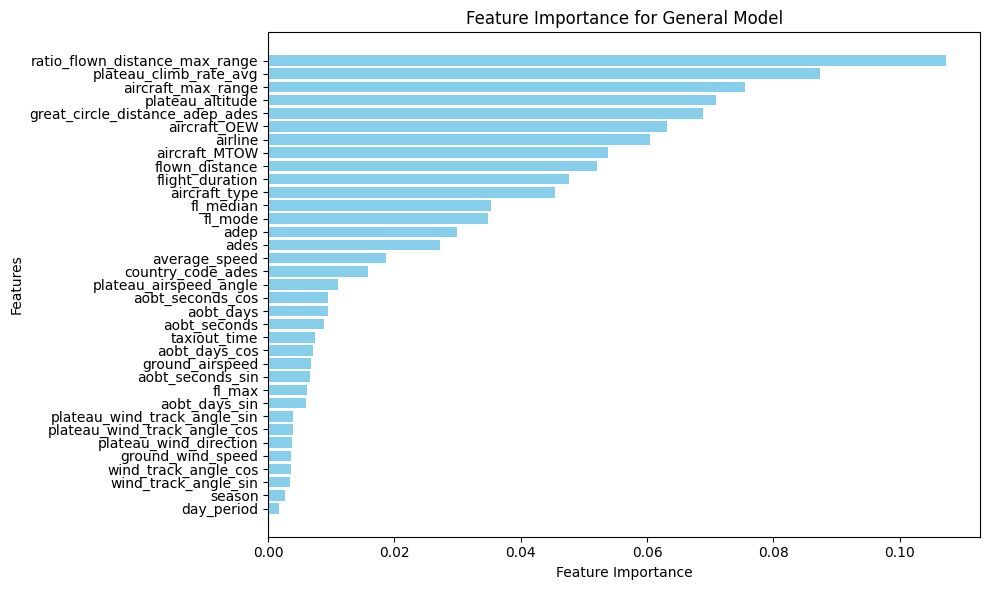

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# Load the dataset into a DataFrame
df_flight = pd.read_csv(os.path.join(source_data_folder,challenge_file_preproc))

# Filter the DataFrame to keep only rows where load_ratio is between 0 and 1
df_flight = df_flight[(df_flight['load_ratio'] > 0) & (df_flight['load_ratio'] < 1)]

# List of categorical columns to be encoded
categorical_cols = [
    'adep',
    'country_code_adep',
    'ades',
    'country_code_ades',
    'airline',
    'aircraft_type',
    'wtc',
    'country_code_adep_icao',
    'country_code_ades_icao',
    'country_code_icao_couple'
]
categorical_cols_tmp=[]
for feature in categorical_cols:
    if feature in df_flight.columns:
        categorical_cols_tmp.append(feature)
    else:
        print("{} is missing in data set!!".format(feature))
        
categorical_cols=categorical_cols_tmp

# Initialize LabelEncoder to convert categorical variables to numerical
le = LabelEncoder()
for col in categorical_cols:
    df_flight[col] = le.fit_transform(df_flight[col])  # Encode each categorical column

# Prepare selected features for the model, combining features from all categories
selected_features = [
    'adep', 'ades', 'flight_duration',
    'great_circle_distance_adep_ades', 'aircraft_type',
    'country_code_ades', 'average_speed',
    'fl_mode','fl_max','fl_median', 'airline', 'taxiout_time',
    'season', 'day_period',
    'aircraft_OEW', 'plateau_climb_rate_avg', 'plateau_altitude',
    'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
    'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
    'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
    'aobt_seconds', 'aobt_days', 'country_code_ades_icao', 'country_code_adep_icao',
    'country_code_icao_couple', 'taxi_in', 'aircraft_max_range', 'flown_distance',
    'aircraft_MTOW', 'ratio_flown_distance_max_range'
]

selected_features_tmp=[]
for feature in selected_features:
    if feature in df_flight.columns:
        selected_features_tmp.append(feature)
    else:
        print("{} is missing in data set!!".format(feature))
        
selected_features=selected_features_tmp

# Prepare features (X) and target variable (y) for the model
X = df_flight[selected_features]
y = df_flight['load_ratio']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor model
model = RandomForestRegressor(
    n_estimators=100,  # Set the number of trees in the forest
    max_depth=300,      # Set the maximum depth of each tree
    min_samples_split=10,  # Set the minimum number of samples required to split an internal node
    min_samples_leaf=5,    # Set the minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Use the square root of the number of features for splitting
    random_state=42
)

model.fit(X_train, y_train)  # Fit the model to the training data

# Predict the load_ratio on the test set
load_ratio_pred = model.predict(X_test)

# Create a DataFrame for test data and predicted values
df_test = X_test.copy()
df_test['load_ratio_pred'] = load_ratio_pred
df_test['aircraft_MTOW'] = df_flight.loc[X_test.index, 'aircraft_MTOW'].values
df_test['aircraft_OEW'] = df_flight.loc[X_test.index, 'aircraft_OEW'].values

# Calculate the predicted 'tow' using the predicted load ratio
df_test['tow_pred'] = df_test['load_ratio_pred'] * (df_test['aircraft_MTOW'] - df_test['aircraft_OEW']) + df_test['aircraft_OEW']

# Calculate the RMSE for the predictions
rmse = np.sqrt(mean_squared_error(df_test['tow_pred'], df_flight.loc[X_test.index, 'tow']))
print(f'RMSE for the general model is {rmse}')

# Create an output directory for saving the model if it doesn't exist
output_dir = './models_general'
os.makedirs(output_dir, exist_ok=True)

# Save the trained model to a .pkl file
model_filename = os.path.join(output_dir, 'random_forest_model_general.pkl')
joblib.dump(model, model_filename)

# Get feature importances from the trained model
feature_importances = model.feature_importances_

# Sort features and their importances
sorted_idx = np.argsort(feature_importances)  # Get indices of features sorted by importance
sorted_features = np.array(selected_features)[sorted_idx]
sorted_importances = feature_importances[sorted_idx]

# Visualize feature importances using a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')  # X-axis label
plt.ylabel('Features')             # Y-axis label
plt.title('Feature Importance for General Model')  # Plot title
plt.tight_layout()  # Adjust layout to fit labels
plt.show()  # Display the feature importance plot

# Save RMSE results into a CSV file for further analysis
rmse_df = pd.DataFrame({'RMSE': [rmse]})
rmse_df.to_csv('./rmse_results_general.csv', index=False)  # Save to CSV


# Generate submission file for common model
This model does not segment depending on aircraft type (Heavy, Medium, Light)

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt  # Import matplotlib for feature importance visualization
from datetime import datetime

# Load the final file
df_final = pd.read_csv(os.path.join(source_data_folder,submission_file_preproc))

# List of categorical columns to be encoded
categorical_cols = [
    'adep',
    'country_code_adep',
    'ades',
    'country_code_ades',
    'airline',
    'aircraft_type',
    'wtc', 
    'country_code_adep_icao',
    'country_code_ades_icao',
    'country_code_icao_couple'
]
categorical_cols_tmp=[]
for feature in categorical_cols:
    if feature in df_final.columns:
        categorical_cols_tmp.append(feature)
    else:
        print("{} is missing in data set!!".format(feature))
        
categorical_cols=categorical_cols_tmp
# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df_final[col] = le.fit_transform(df_final[col])

# Load the unique model
model_filename = './models_general/random_forest_model_general.pkl'
if os.path.exists(model_filename):
    model = joblib.load(model_filename)
else:
    raise FileNotFoundError(f"The model file was not found at {model_filename}")

# Selected features for the model
selected_features = [
    'adep', 'ades', 'flight_duration',
    'great_circle_distance_adep_ades', 'aircraft_type',
    'country_code_ades', 'average_speed',
    'fl_mode','fl_max','fl_median', 'airline', 'taxiout_time',
    'season', 'day_period',
    'aircraft_OEW', 'plateau_climb_rate_avg', 'plateau_altitude',
    'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
    'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
    'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
    'aobt_seconds', 'aobt_days', 'country_code_ades_icao', 'country_code_adep_icao',
    'country_code_icao_couple', 'taxi_in', 'aircraft_max_range', 'flown_distance',
    'aircraft_MTOW', 'ratio_flown_distance_max_range'
]

selected_features_tmp=[]
for feature in selected_features:
    if feature in df_final.columns:
        selected_features_tmp.append(feature)
    else:
        print("{} is missing in data set!!".format(feature))
        
selected_features=selected_features_tmp

# Function to predict 'load_ratio' and calculate 'tow'
def predict_and_calculate_tow(df, model):
    if df.empty or model is None:
        return df
    
    # Predict load_ratio
    X = df[selected_features]
    
    df['load_ratio_pred'] = model.predict(X)
    
    # Calculate tow
    df['tow'] = df['load_ratio_pred'] * (df['aircraft_MTOW'] - df['aircraft_OEW']) + df['aircraft_OEW']
    
    return df
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
print("Current date & time : ", current_datetime)
# Predict and calculate 'tow' for the entire dataset
df_final = predict_and_calculate_tow(df_final, model)

submission_file_name='./'+current_datetime+'_final_submission_set_with_tow.csv'
# Save the final file with the tow predictions
df_final.to_csv(submission_file_name, index=False)

print("The final file with the 'tow' predictions has been saved as '{}'.".format(submission_file_name))

print(df_final.columns)
print(df_final[["flight_id","load_ratio_pred","tow"]])


country_code_adep_icao is missing in data set!!
country_code_ades_icao is missing in data set!!
country_code_icao_couple is missing in data set!!
country_code_ades_icao is missing in data set!!
country_code_adep_icao is missing in data set!!
country_code_icao_couple is missing in data set!!
taxi_in is missing in data set!!
Current date & time :  20241025_164940
The final file with the 'tow' predictions has been saved as './20241025_164940_final_submission_set_with_tow.csv'.
Index(['flight_id', 'date', 'callsign', 'adep', 'name_adep',
       'country_code_adep', 'ades', 'name_ades', 'country_code_ades',
       'actual_offblock_time', 'arrival_time', 'aircraft_type', 'wtc',
       'airline', 'flight_duration', 'taxiout_time', 'flown_distance', 'tow',
       'aircraft_category', 'aircraft_OEW', 'aircraft_ZFW',
       'aircraft_max_range', 'aircraft_MTOW', 'load_ratio',
       'ratio_flown_distance_max_range', 'fl_mode', 'fl_max', 'fl_median',
       'plateau_climb_rate_avg', 'plateau_alti

# Generate file for segmented model

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt  # Import matplotlib for feature importance visualization

# Load the final file
df_flight = pd.read_csv(os.path.join(source_data_folder,submission_file_preproc))

# List of categorical columns to be encoded
categorical_cols = [
    'adep',
    'country_code_adep',
    'ades',
    'country_code_ades',
    'airline',
    'aircraft_type',
    'wtc', 
    'country_code_adep_icao',
    'country_code_ades_icao',
    'country_code_icao_couple'
]

categorical_cols_tmp=[]
for feature in categorical_cols:
    if feature in df_category.columns:
        categorical_cols_tmp.append(feature)
    else:
        print("{} is missing in data set!!".format(feature))
        
categorical_cols=categorical_cols_tmp

# Encode categorical columns
le = LabelEncoder()
for col in categorical_cols:
    df_flight[col] = le.fit_transform(df_flight[col])

# Create a dictionary to load models by category
models = {}

# Aircraft categories
aircraft_categories = ['Medium', 'Heavy', 'Light']

# Create the directory if it does not exist
output_dir = './models_by_aircraft_category'
os.makedirs(output_dir, exist_ok=True)

# Load models for each aircraft category
for category in aircraft_categories:
    model_filename = os.path.join(output_dir, f'random_forest_model_{category}.pkl')
    if os.path.exists(model_filename):
        models[category] = joblib.load(model_filename)
    else:
        print(f"The model for category {category} was not found.")

# Function to predict 'load_ratio' and calculate 'tow'
def predict_and_calculate_tow(df, category, model):
    if df.empty or model is None:
        return df
    
    # Define selected features based on the aircraft category
    if category == 'Medium':
        selected_features = [
            'adep', 'ades', 'flight_duration',
            'great_circle_distance_adep_ades', 'aircraft_type',
            'country_code_ades', 'average_speed',
            'fl_mode','fl_median'
            'adep_ades', 'airline', 'great_circle_flown_distance',
            'season', 'day_period',
            'aircraft_OEW', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'country_code_ades_icao', 'country_code_adep_icao',
            'country_code_icao_couple', 'taxi_in', 'aircraft_max_range', 'flown_distance'
        ]

    elif category == 'Heavy':
        selected_features = [
            'adep', 'ades', 'flight_duration', 'flown_distance',
            'aircraft_type', 'country_code_ades', 'average_speed',
            'fl_mode','fl_max','fl_median', 'airline', 'taxiout_time',
            'season', 'day_period', 'country_code_adep',
            'aircraft_MTOW', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',                
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'country_code_adep_icao', 'country_code_ades_icao'
        ]

    elif category == 'Light':
        selected_features = [
            'adep', 'ades', 'flight_duration',
            'great_circle_distance_adep_ades', 'aircraft_type',
            'country_code_ades', 'average_speed',
            'fl_mode','fl_median', 'airline', 'country_code_adep',
            'day_period', 'plateau_climb_rate_avg', 'plateau_altitude',
            'aobt_seconds_cos', 'aobt_seconds_sin', 'aobt_days_cos', 'aobt_days_sin',
            'ground_airspeed','ground_wind_speed','wind_track_angle_cos','wind_track_angle_sin',
            'plateau_wind_track_angle_cos','plateau_wind_track_angle_sin','plateau_wind_direction','plateau_airspeed_angle',
            'aobt_seconds', 'aobt_days', 'taxi_in', 'ratio_flown_distance_max_range'
        ]
    
    selected_features_tmp=[]
    for feature in selected_features:
        if feature in df.columns:
            selected_features_tmp.append(feature)
        else:
            print("{} is missing in data set!!".format(feature))
        
    selected_features=selected_features_tmp
    # Predict load_ratio
    X = df[selected_features]
    df['load_ratio_pred'] = model.predict(X)
    
    # Calculate tow
    df['tow'] = df['load_ratio_pred'] * (df['aircraft_MTOW'] - df['aircraft_OEW']) + df['aircraft_OEW']
    
    return df

# Loop through each aircraft category to predict and calculate tow
for category in aircraft_categories:
    df_category_final = df_flight[df_flight['aircraft_category'] == category]
    model = models.get(category)
    
    if model:
        df_flight.loc[df_flight['aircraft_category'] == category, 'tow'] = predict_and_calculate_tow(df_category_final, category, model)['tow']
    else:
        print(f"No model available for category {category}")

print("Current date & time : ", current_datetime)
# Predict and calculate 'tow' for the entire dataset

submission_file_name='./'+current_datetime+'_final_submission_set_with_tow_per_cat.csv'
# Save the final file with the tow predictions
df_final.to_csv(submission_file_name, index=False)

print("The final file with the 'tow' predictions has been saved as 'final_submission_set_with_tow.csv'.")

country_code_adep_icao is missing in data set!!
country_code_ades_icao is missing in data set!!
country_code_icao_couple is missing in data set!!
fl_medianadep_ades is missing in data set!!
country_code_ades_icao is missing in data set!!
country_code_adep_icao is missing in data set!!
country_code_icao_couple is missing in data set!!
taxi_in is missing in data set!!


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- aircraft_max_range
Feature names seen at fit time, yet now missing:
- adep_ades
- fl_max
- fl_median


# Post-processing
Check that the data is within the aircraft weight limits

In [34]:
import pandas as pd

# Load the updated test file with 'load_ratio' predictions
df_submission = pd.read_csv(submission_file_name)
print(df_submission[["flight_id","load_ratio_pred","tow"]])

# Filter the rows where 'tow' is less than 'aircraft_OEW' or greater than 'aircraft_MTOW'
out_of_bounds = df_submission[(df_submission['tow'] < df_submission['aircraft_OEW']) | (df_submission['tow'] > df_submission['aircraft_MTOW'])]

# Display the number of rows where the condition is met
print(f"\nNumber of rows where 'tow' is less than 'aircraft_OEW' or greater than 'aircraft_MTOW': {len(out_of_bounds)}")

# Optional: Display a preview of the affected rows
print("\nPreview of rows where 'tow' is out of bounds:")
print(out_of_bounds.head())


        flight_id  load_ratio_pred            tow
0       248753821         0.672341   66680.022653
1       248753822         0.749506  212136.158934
2       248754498         0.358743  233701.077166
3       248763650         0.617437   64615.620760
4       248763651         0.439682   51961.237342
...           ...              ...            ...
158144  258068876         0.549593   73231.684604
158145  258064675         0.502270   60380.341857
158146  258065436         0.394227  200682.038095
158147  258058138         0.606405   42049.437098
158148  258058370         0.604294   64121.471579

[158149 rows x 3 columns]

Number of rows where 'tow' is less than 'aircraft_OEW' or greater than 'aircraft_MTOW': 0

Preview of rows where 'tow' is out of bounds:
Empty DataFrame
Columns: [flight_id, date, callsign, adep, name_adep, country_code_adep, ades, name_ades, country_code_ades, actual_offblock_time, arrival_time, aircraft_type, wtc, airline, flight_duration, taxiout_time, flown_distance

# Cleanup file for submission

In [35]:
df = pd.read_csv(submission_file_name)

df_submission_final = df[['flight_id',                         
                           'tow']]

current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

submission_file_final_name='./'+current_datetime+'_final_submission_flight_id_tow_only.csv'

# Sauvegarder les résultats dans un nouveau fichier CSV
df_submission_final.to_csv(submission_file_final_name, index=False)
df_submission_final

,flight_id,tow
0,248753821,66680.022653
1,248753822,212136.158934
2,248754498,233701.077166
3,248763650,64615.620760
4,248763651,51961.237342
...,...,...
158144,258068876,73231.684604
158145,258064675,60380.341857
158146,258065436,200682.038095
158147,258058138,42049.437098
